In [1]:
import jax.numpy as jnp
from jax import config, random
from jax.lax import dot_general, scan
from scipy.special import eval_chebyt
import itertools
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Tensor Train

The basic algorithm for tensor train decomposition

In [2]:
def adaptive_TT(A, delta):
    r0 = 1
    C = A.copy()
    TT_cores = []
    for k in range(C.ndim-1):
        C = C.reshape(r0*A.shape[k], -1)
        U, S, V = jnp.linalg.svd(C, full_matrices=False)
        keep = ((jnp.sqrt(jnp.cumsum(S[::-1]**2))) >= delta)[::-1]
        r = jnp.sum(keep)
        TT_cores.append(U[:, keep].reshape(r0, A.shape[k], r))
        C = (V[keep] * jnp.expand_dims(S[keep], 1))
        r0 = r
    TT_cores.append(C)
    TT_cores[0] = TT_cores[0].reshape(TT_cores[0].shape[1:])
    return TT_cores

def evaluate_TT(cores):
    res = cores[-1]
    for core in cores[::-1][1:]:
        res = dot_general(core, res, (((core.ndim-1,), (0,)), ((), ())))
    return res

In [3]:
key = random.PRNGKey(13)
A = random.normal(key, (2, 5, 2, 6, 7, 4))
F = jnp.sqrt(jnp.sum(A**2))
epsilon = 1e-2
delta = F*epsilon / jnp.sqrt(A.ndim - 1)

TT_cores = adaptive_TT(A, delta)

In [4]:
total_size = 0
for core in TT_cores:
    total_size += core.size
    print(core.shape)

compression_factor = total_size / A.size
print(f"Compression factor {compression_factor}")

(2, 2)
(2, 5, 10)
(10, 2, 20)
(20, 6, 28)
(28, 7, 4)
(4, 4)
Compression factor 1.388095238095238


In [5]:
A_tt = evaluate_TT(TT_cores)
relative_error = jnp.sqrt(jnp.sum((A_tt - A)**2)) / F
relative_error

DeviceArray(3.52846419e-15, dtype=float64)

## Example 1: QTT

QTT is a way to compress a function based on binary folding.

For a chosen number of levels $J$, we have a grid subdivision on $2^J$ regions.

Below, the example is given for $J = 3$.

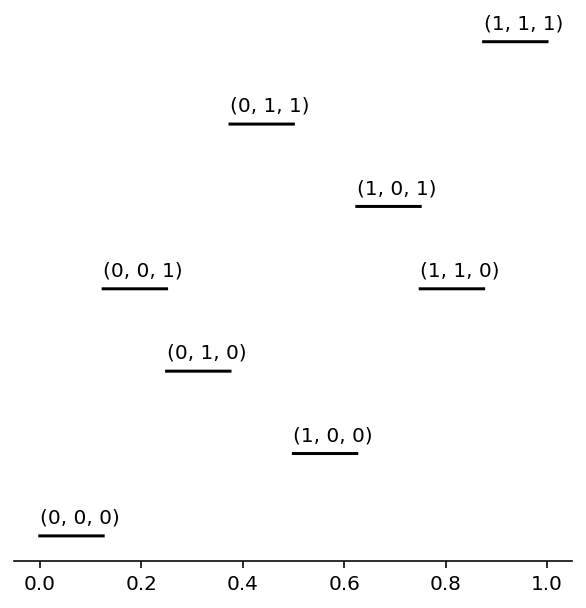

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
x = jnp.linspace(0, 1, 2**16).reshape([2,]*3 + [-1,])
for i, j, k in itertools.product(range(2), repeat=3):
    ax.plot(x[i, j, k], 1*i + 2*j + 3*k + 0*x[i, j, k], color="black")
    c = x[i, j, k][0]
    ax.text(c, 1*i + 2*j + 3*k + 0.15, f"({i}, {j}, {k})")

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yticklabels([])
ax.yaxis.set_ticks([])
plt.minorticks_off();

The first index equals $1$ if the point is on the right side of the interval (has $x \leq 0.5$) and $0$ otherwise.

The second index equals $1$ if the point is on the right side of the subinterval $[0, 0.5]$ or $[0.5, 1]$ and zero otherwise.

For example, consider the point $0.3$. Let's find its index $(a, b, c)$:

1. $0.3 \leq 0.5 \longrightarrow a = 0$
2. $0.3 \geq 0.25 \longrightarrow b = 1$
2. $0.3 \leq (0.5 + 0.25) \big/ 2 \longrightarrow c = 0$


Suppose that the function is sampled at a set of points. For simplicity, we take a uniform grid with $2^{J_1}$ points.

Folding with $J$ levels that we just described, transform array with $2^{J_1}$ samples to the tensor with shape $(\underbrace{2, \dots, 2}_{\text{J }}, 2^{J_1 - J})$. Now we can apply TT approximation to the first $J$ dimensions.

Below we show the example with $J_1 = J$, but it is straightforward to ignore the remaining point by _coarsening_, i.e., we can fit each function on the remaining interval with, say, polynomial of degree $3$. This way we will need to perform $3$ QTT transforms - one for each coefficient.

The standard QTT on the grid with $2^J$ points can be considered as coarsening with constant approximation on the subintervals of size $1 \big/ (2^{J}+1)$. 

In [7]:
def QTT_experiment(f, epsilon=1e-3):
    J = f.ndim
    norm = jnp.sqrt(jnp.sum(f**2))
    delta = norm*epsilon / jnp.sqrt(J - 1)

    f_ = adaptive_TT(f, delta)

    ranks = []
    total_size = 0
    for i, core in enumerate(f_):
        total_size += core.size
        if i != len(f_): 
            ranks.append(core.shape[-1])

    compression_factor = total_size / f.size
    print(f"Compression factor {compression_factor}")

    f_tt = evaluate_TT(f_)
    relative_error = jnp.sqrt(jnp.sum((f_tt - f)**2)) / norm
    print(f"Relative error {relative_error}")

    fig, ax = plt.subplots(4, 1, figsize=(12, 9))
    ax[0].plot(ranks, "o", color="black")
    ax[0].set_title("TT ranks")

    ax[1].plot(x, f.reshape(-1,) - f_tt.reshape(-1,), color="black")
    ax[1].set_title("absolute error")

    grid = jnp.linspace(0, 1, 2**J)
    ax[2].plot(x, jnp.ravel(f), color="black")
    ax[2].set_title("original function")

    ax[3].plot(x, jnp.ravel(f_tt), color="black")
    ax[3].set_title("approximation")

    plt.tight_layout()

### Trigonometric series

Compression factor 0.0002803802490234375
Relative error 0.00035681473021307935


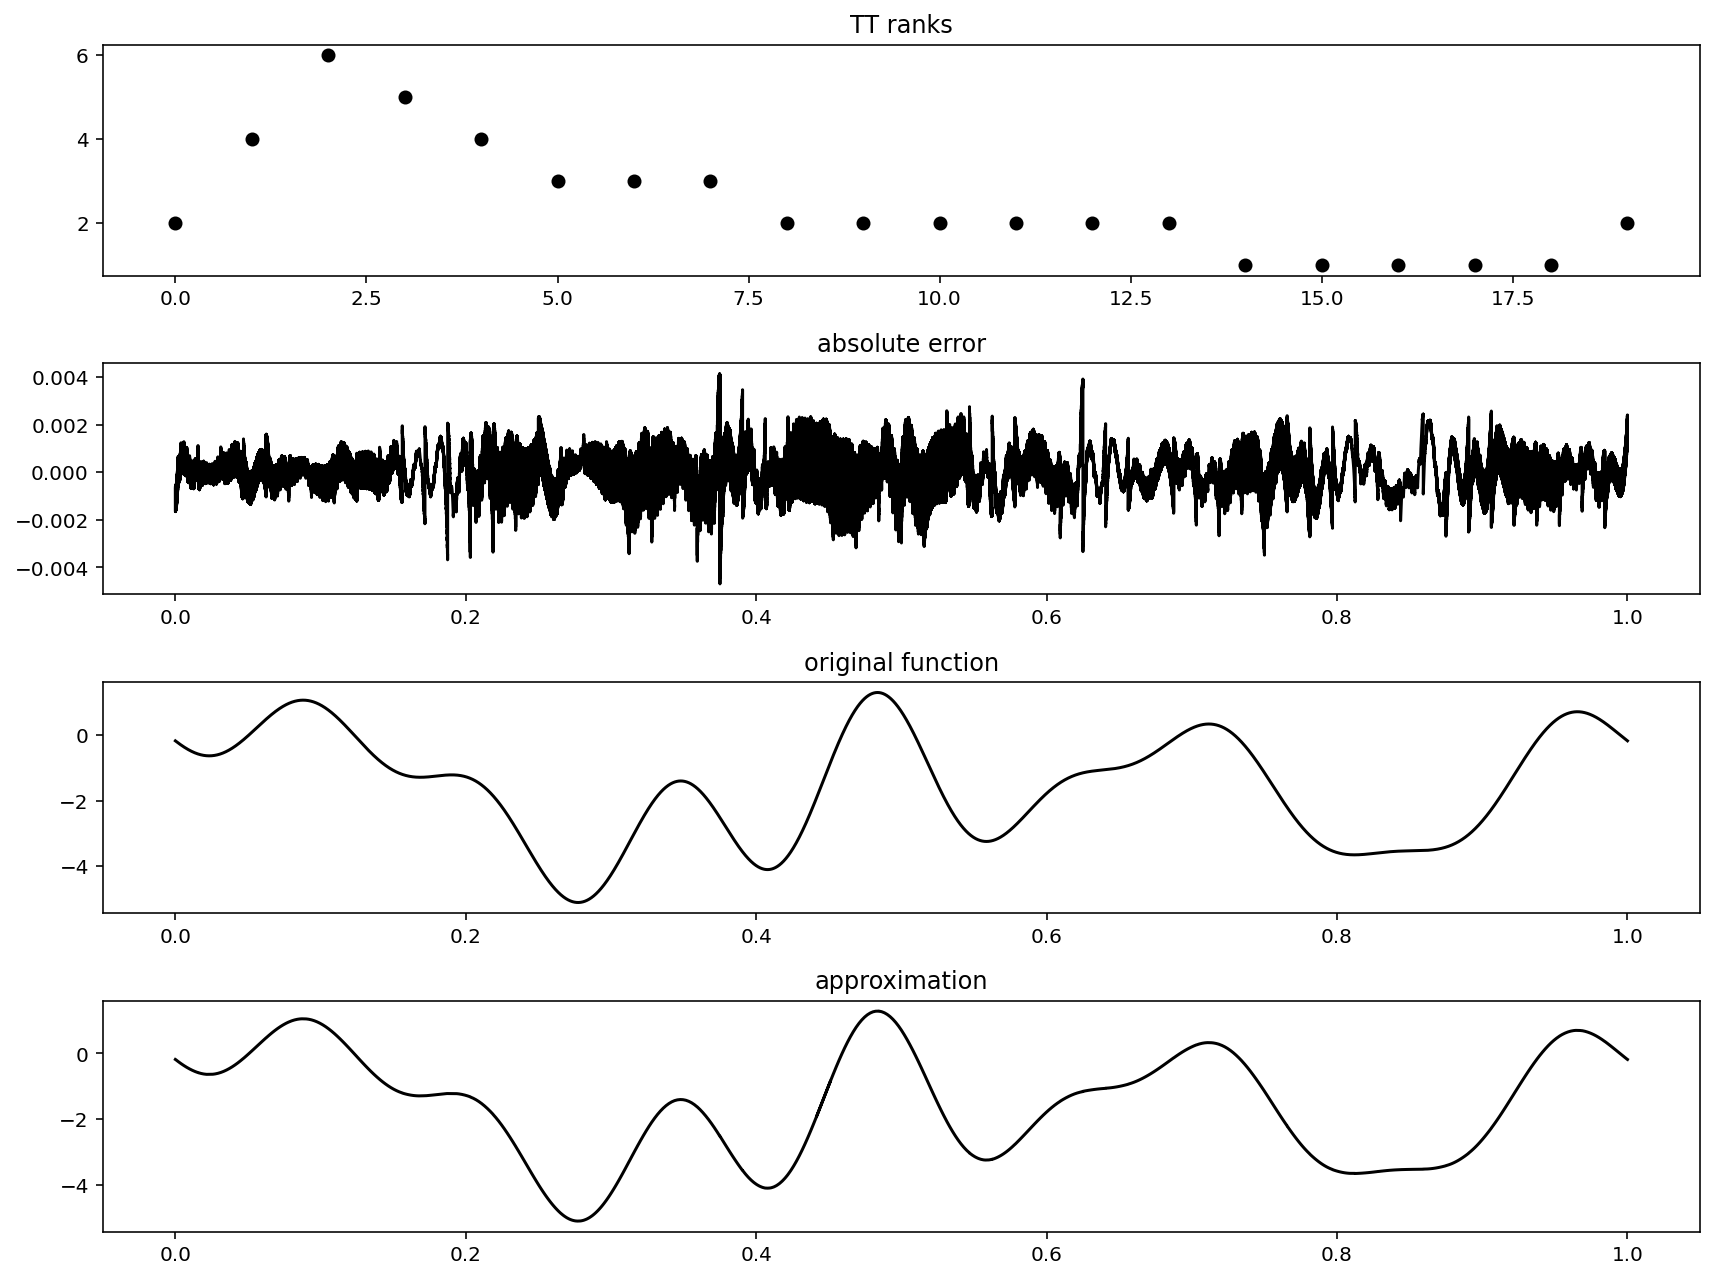

In [8]:
J = 20
n_terms = 10
x = jnp.linspace(0, 1, 2**J)
key = random.PRNGKey(11)
c = random.normal(key, (n_terms,), dtype=jnp.complex128)
f = jnp.sum(jnp.stack([jnp.real(c[n]*jnp.exp(1j*2*jnp.pi*n*x)) for n in range(n_terms)], 0), 0).reshape([2,]*J)
QTT_experiment(f)

### Exp of trigonometric series

Compression factor 0.0004024505615234375
Relative error 0.0004053776438032738


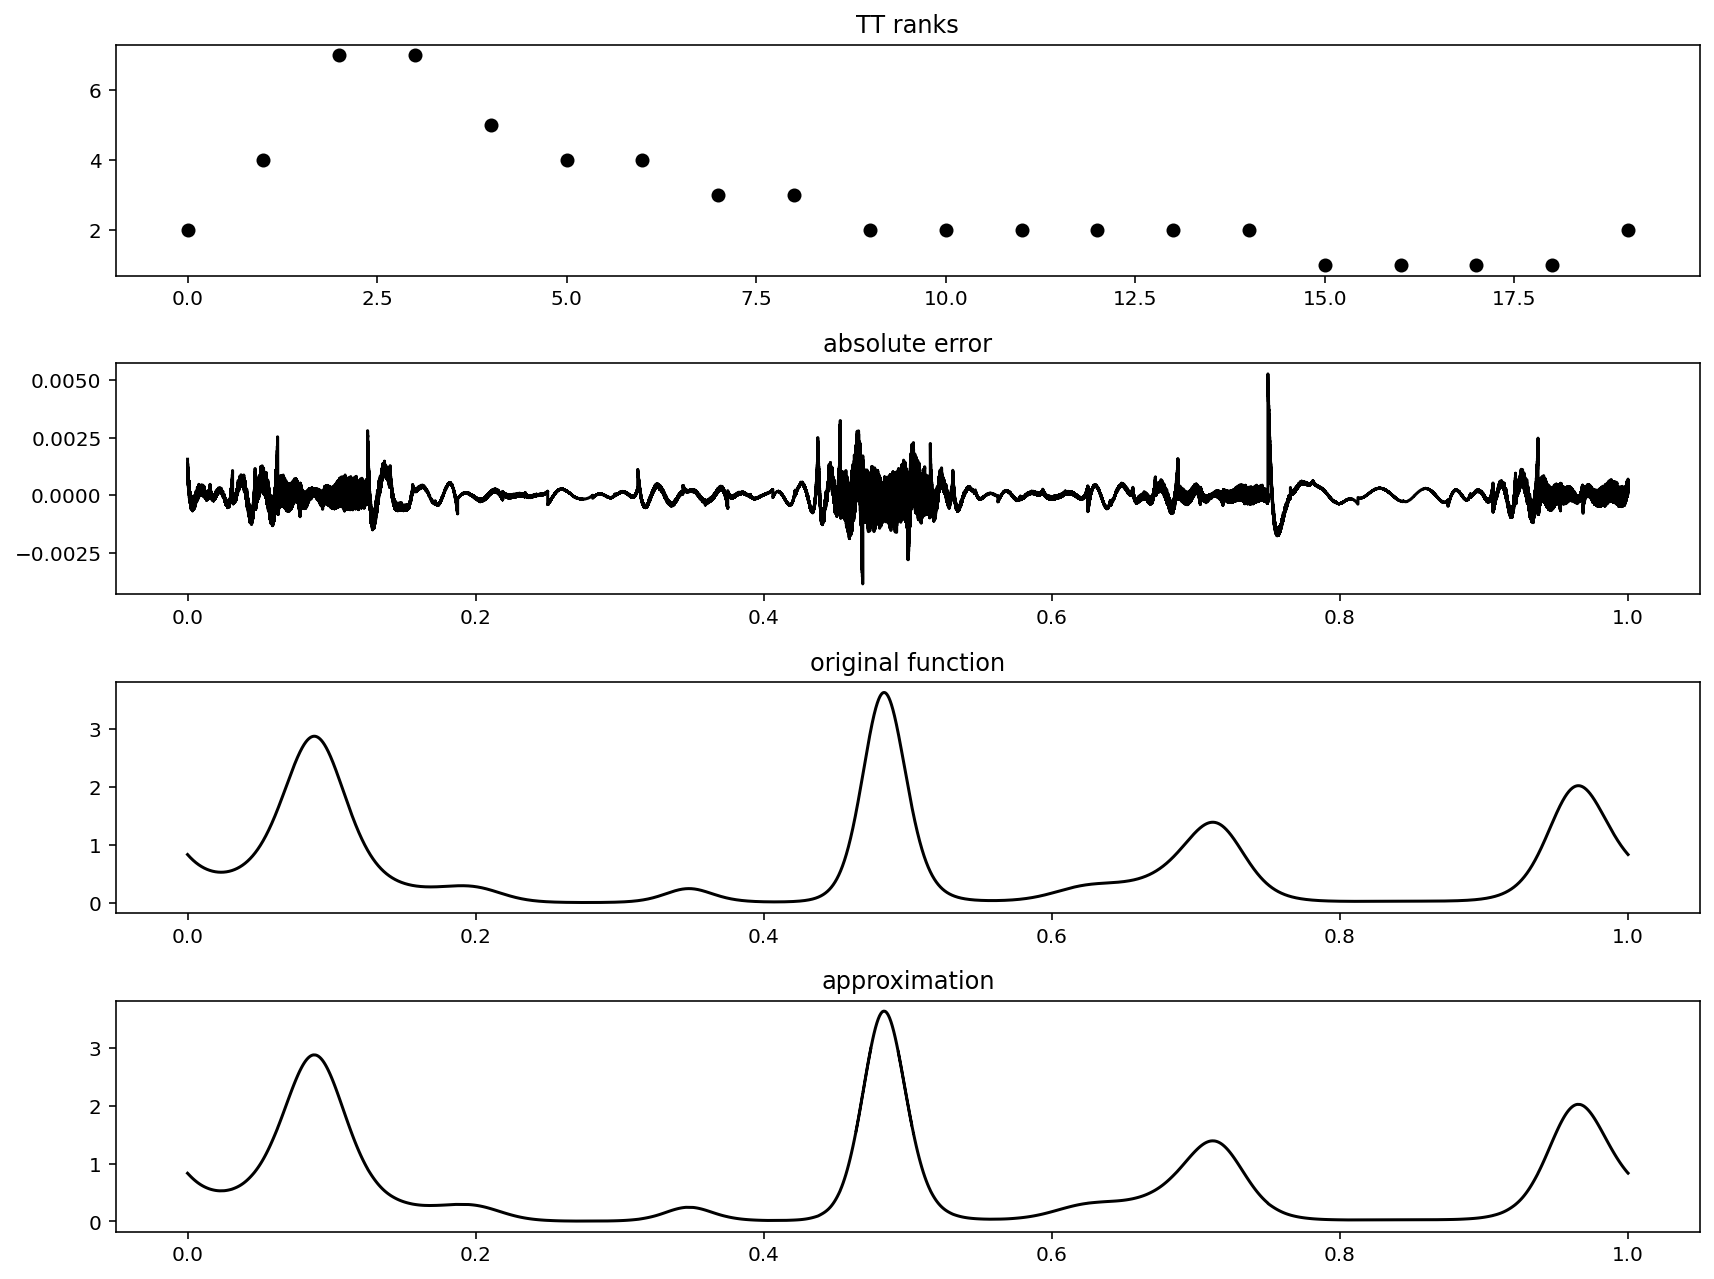

In [9]:
J = 20
n_terms = 10
x = jnp.linspace(0, 1, 2**J)
key = random.PRNGKey(11)
c = random.normal(key, (n_terms,), dtype=jnp.complex128)
f = jnp.exp(jnp.sum(jnp.stack([jnp.real(c[n]*jnp.exp(1j*2*jnp.pi*n*x)) for n in range(n_terms)], 0), 0)).reshape([2,]*J)
QTT_experiment(f)

### Piecewise linear function

Compression factor 0.0001049041748046875
Relative error 0.0002143982786879288


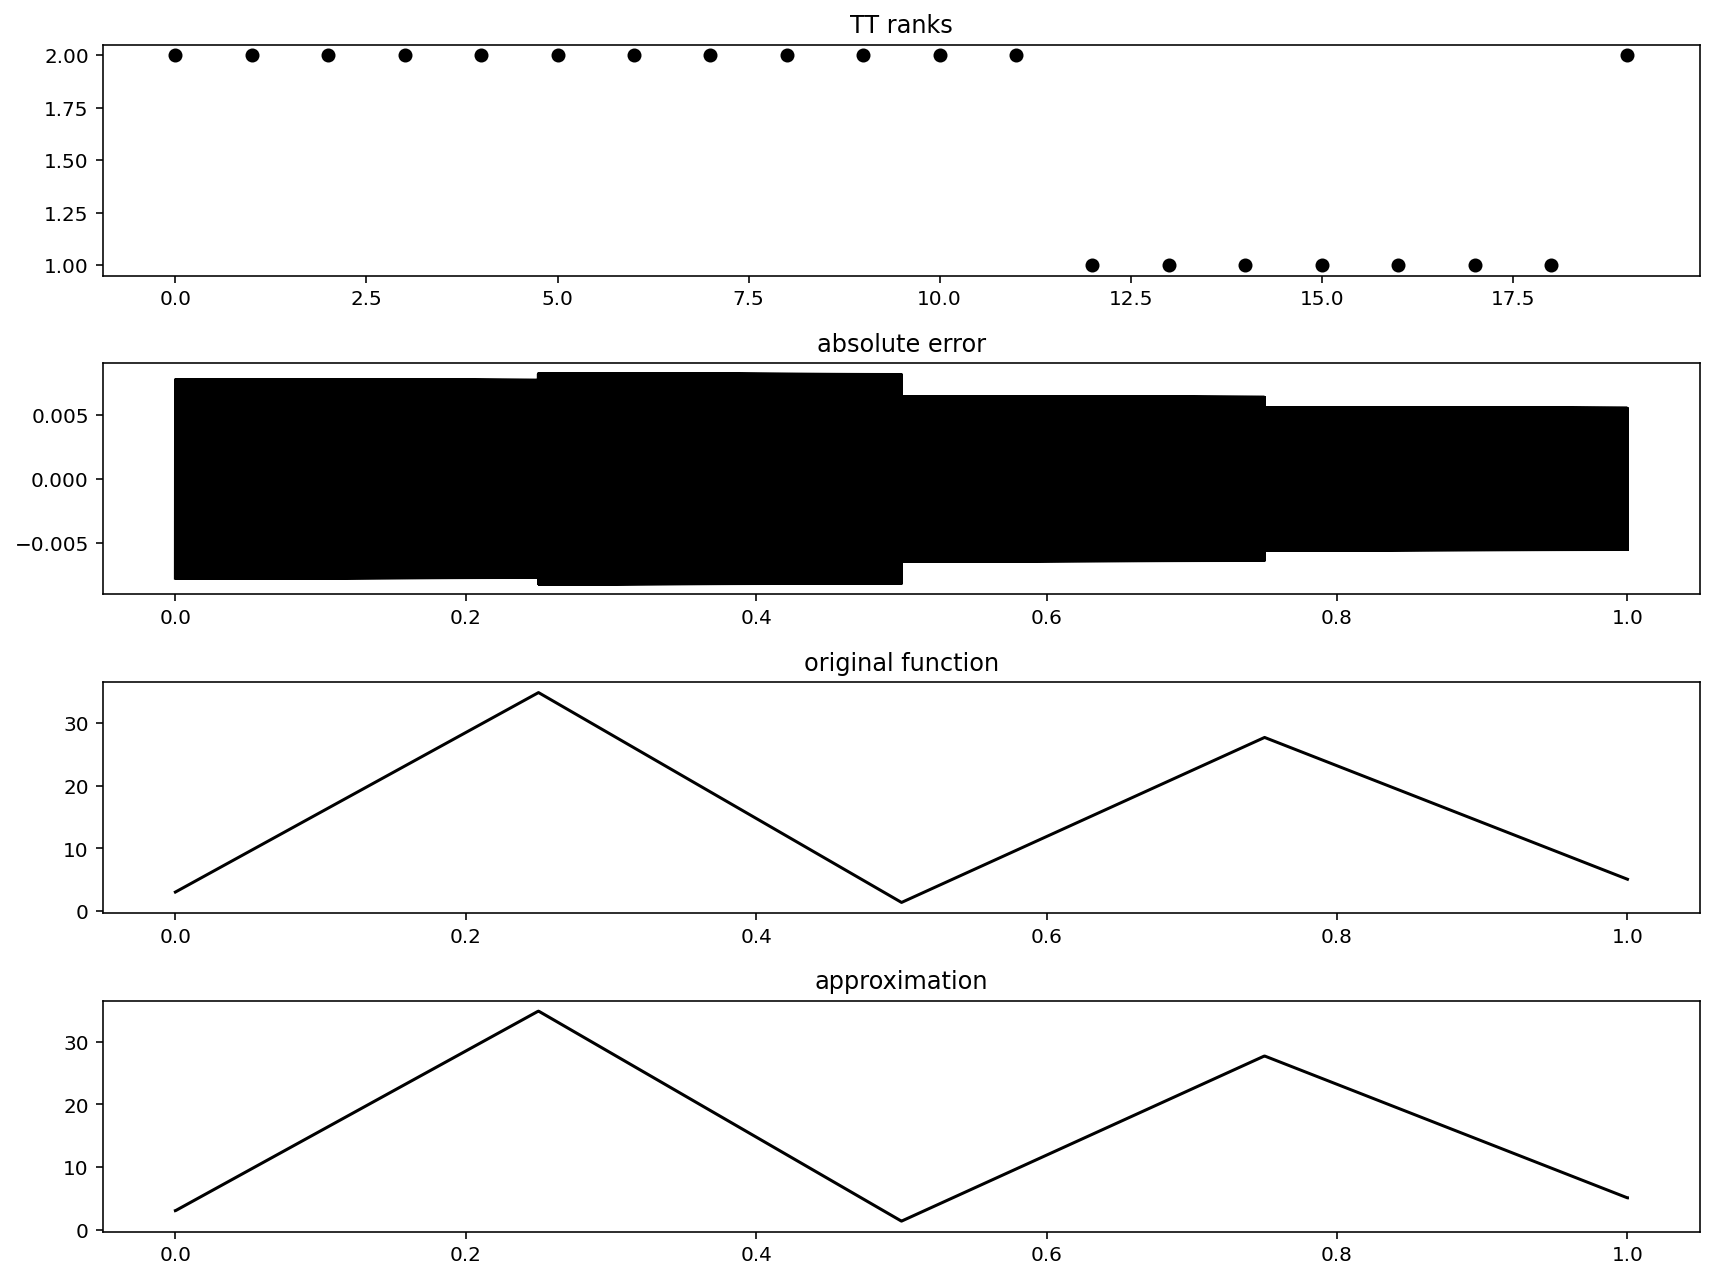

In [10]:
J = 20
x = jnp.linspace(0, 1, 2**J)

n_terms = 5
key = random.PRNGKey(33)
keys = random.split(key, 2)
c = jnp.linspace(0, 1, n_terms)#random.uniform(keys[0], (n_terms,))
v = 20*random.normal(keys[1], (n_terms,))
order = jnp.argsort(c)
c = c[order]
v = v[order]

f = jnp.interp(x, c, v).reshape([2,]*J)
QTT_experiment(f)

Compression factor 0.00025177001953125
Relative error 0.00019961467545062211


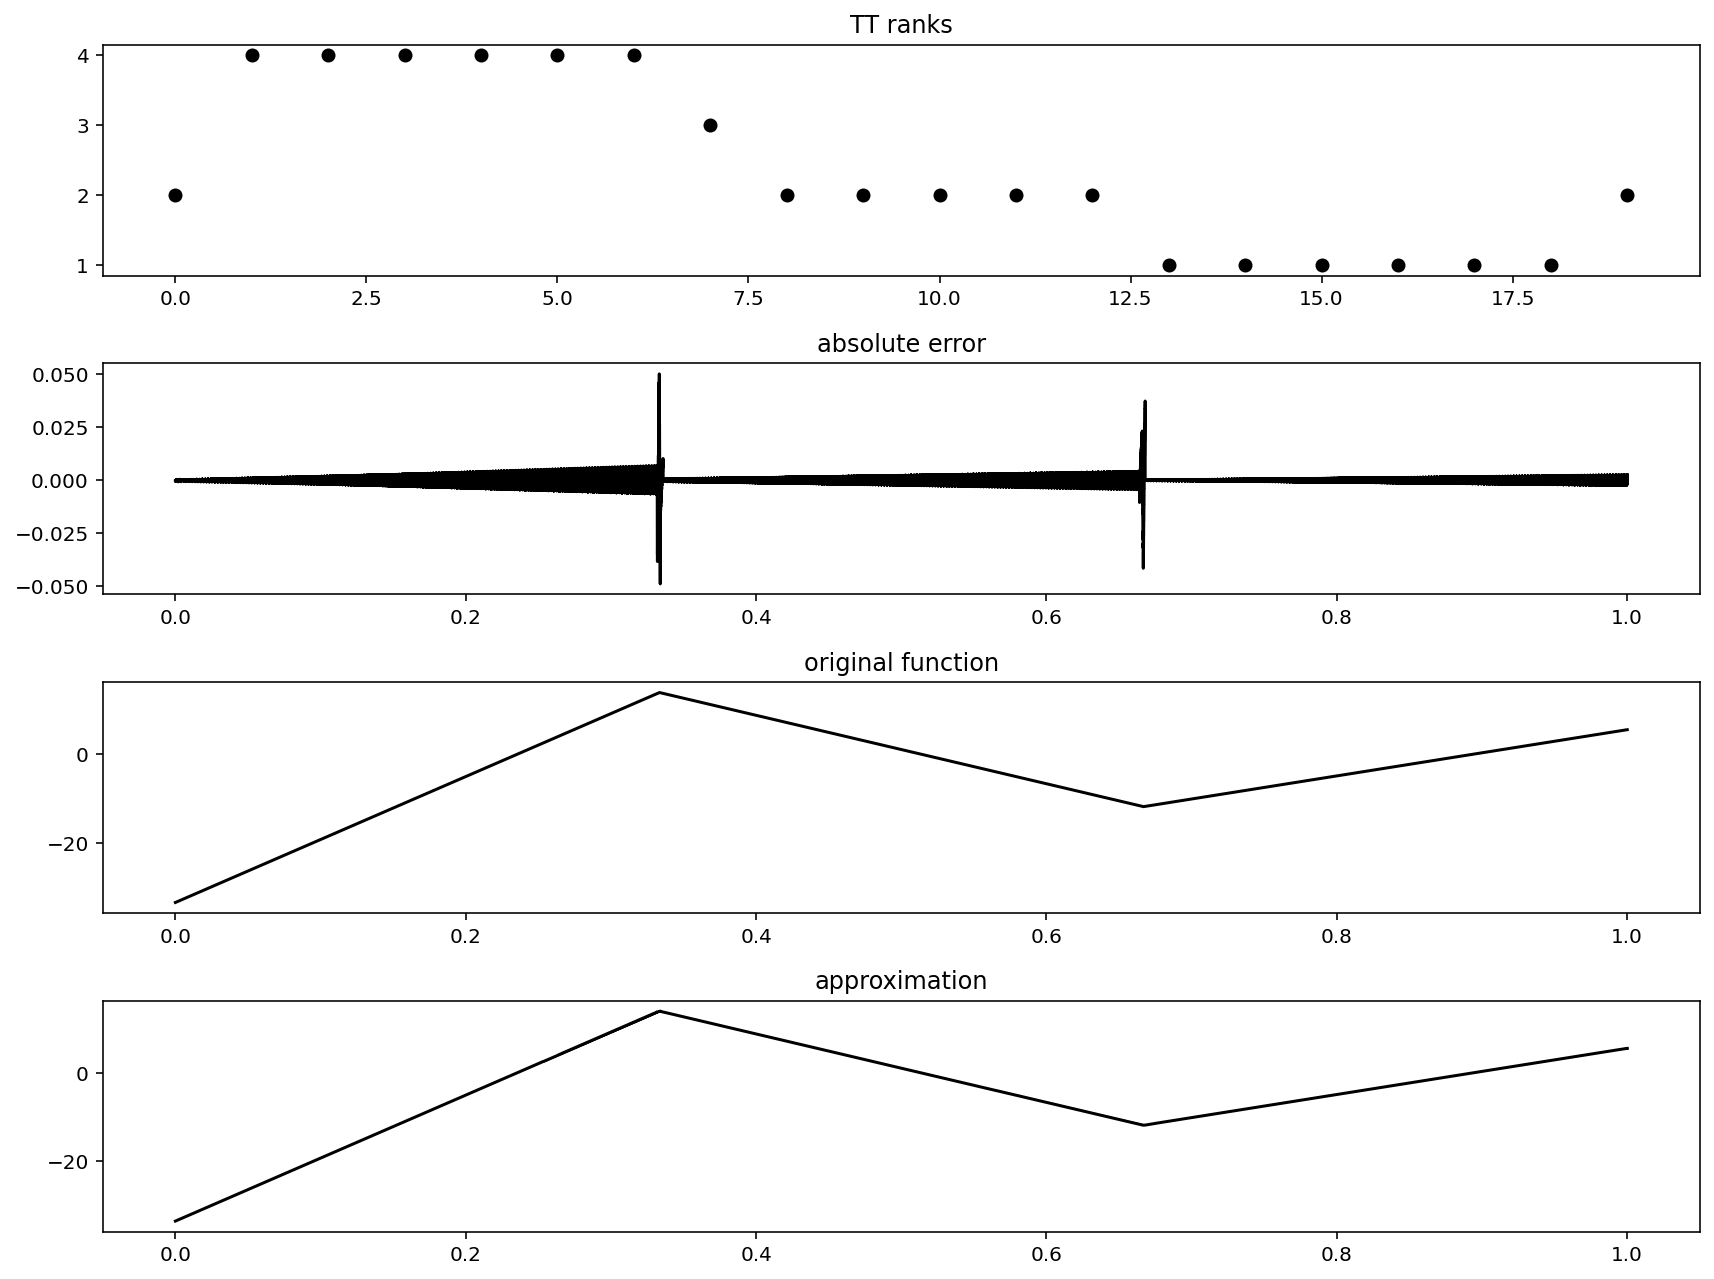

In [11]:
J = 20
x = jnp.linspace(0, 1, 2**J)

n_terms = 4
key = random.PRNGKey(33)
keys = random.split(key, 2)
c = jnp.linspace(0, 1, n_terms)#random.uniform(keys[0], (n_terms,))
v = 20*random.normal(keys[1], (n_terms,))
order = jnp.argsort(c)
c = c[order]
v = v[order]

f = jnp.interp(x, c, v).reshape([2,]*J)
QTT_experiment(f)

Compression factor 0.0007648468017578125
Relative error 0.00034286423197495543


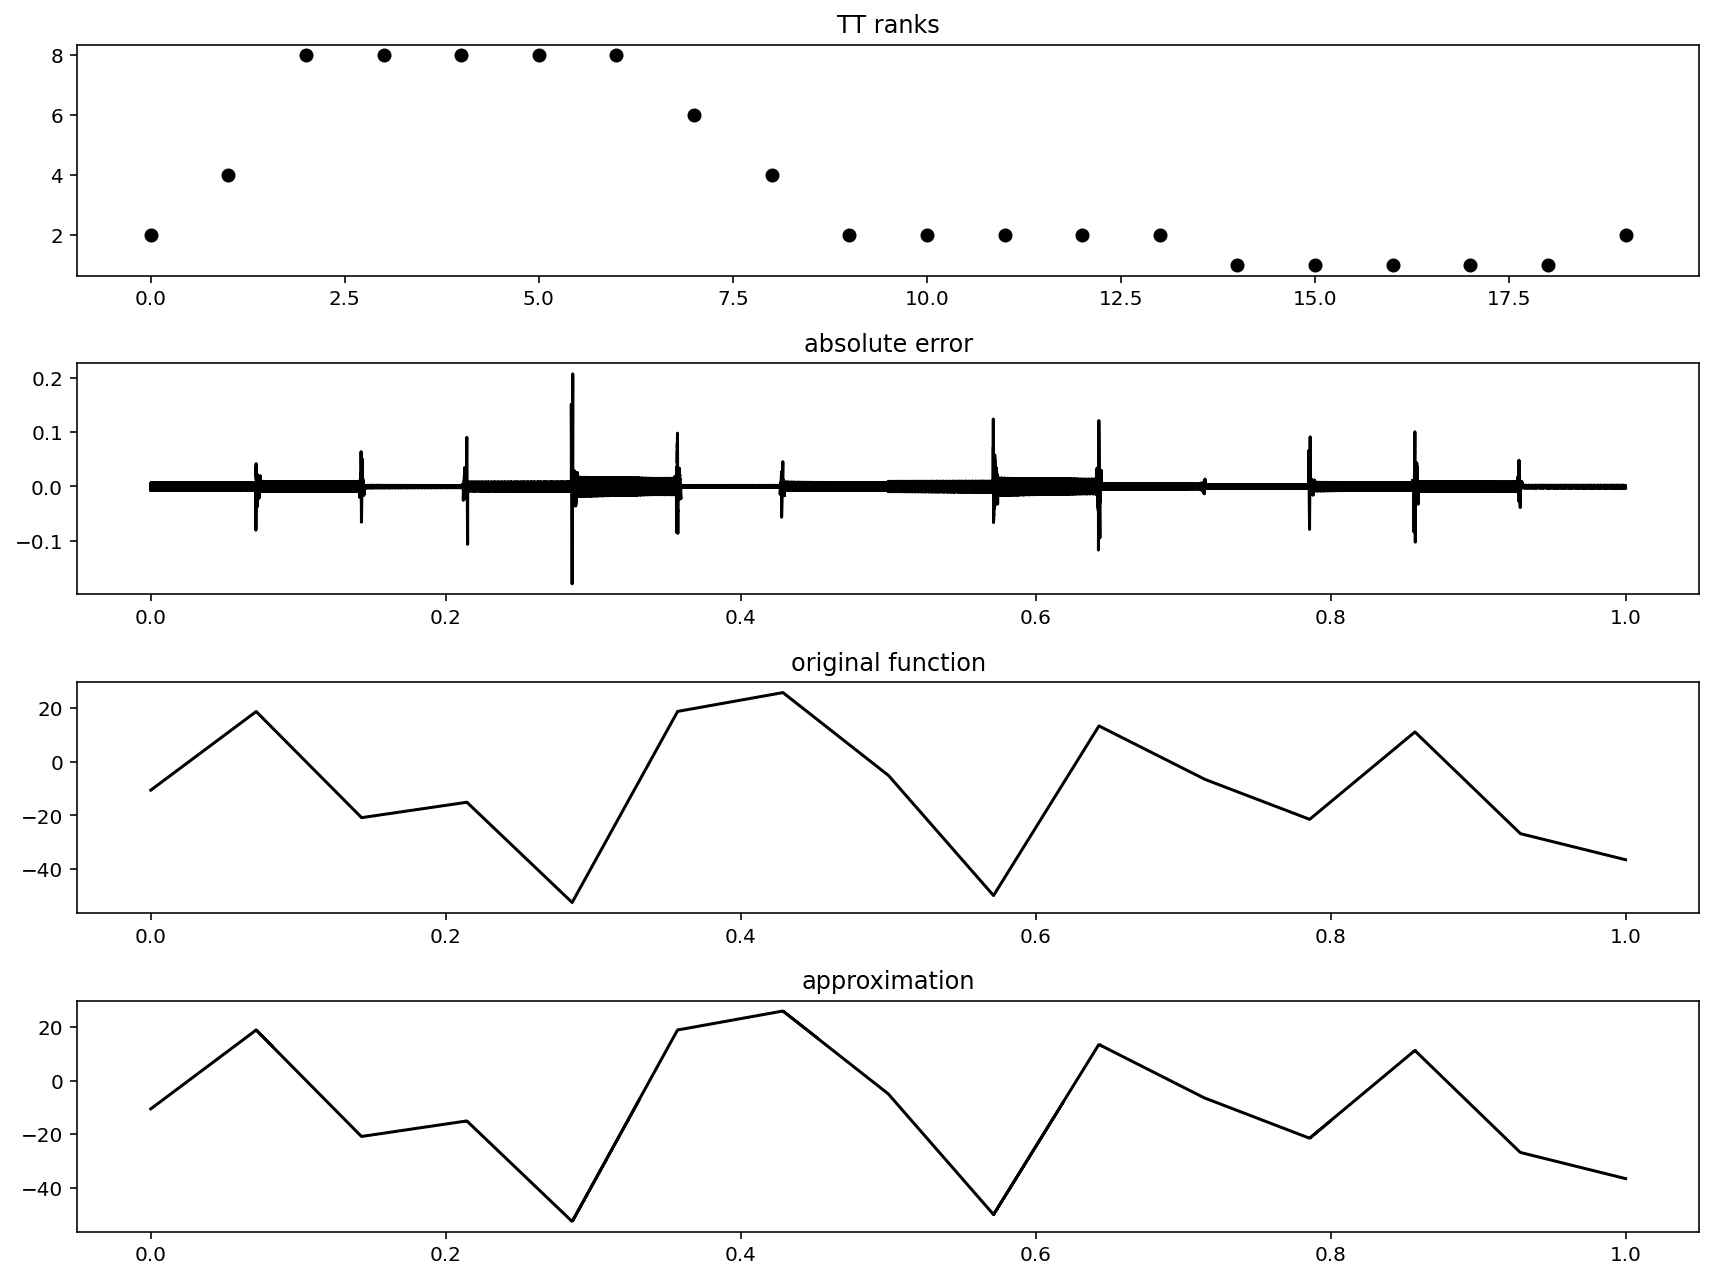

In [12]:
J = 20
x = jnp.linspace(0, 1, 2**J)

n_terms = 15
key = random.PRNGKey(33)
keys = random.split(key, 2)
c = jnp.linspace(0, 1, n_terms)#random.uniform(keys[0], (n_terms,))
v = 20*random.normal(keys[1], (n_terms,))
order = jnp.argsort(c)
c = c[order]
v = v[order]

f = jnp.interp(x, c, v).reshape([2,]*J)
QTT_experiment(f)

Compression factor 0.00507354736328125
Relative error 8.894626034978388e-15


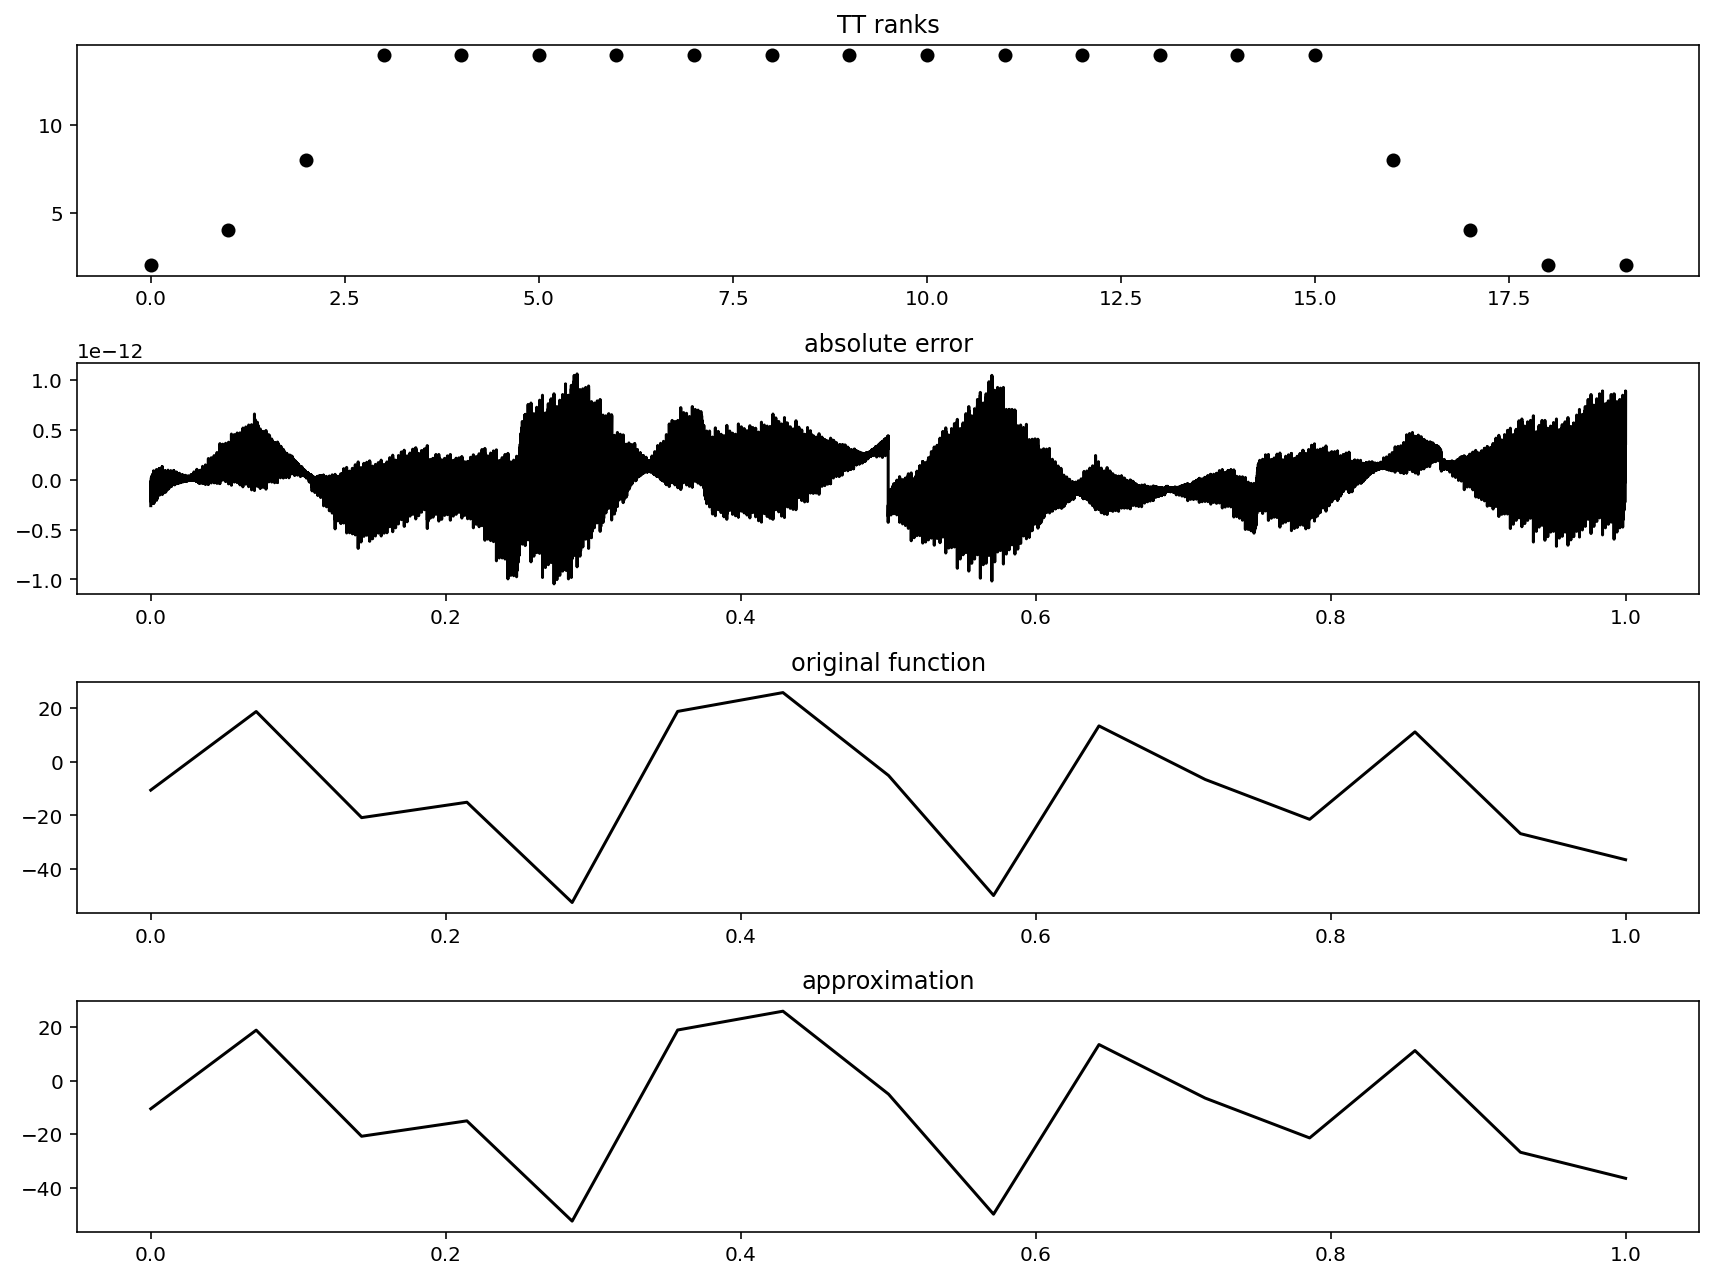

In [13]:
J = 20
x = jnp.linspace(0, 1, 2**J)

n_terms = 15
key = random.PRNGKey(33)
keys = random.split(key, 2)
c = jnp.linspace(0, 1, n_terms)#random.uniform(keys[0], (n_terms,))
v = 20*random.normal(keys[1], (n_terms,))
order = jnp.argsort(c)
c = c[order]
v = v[order]


f = jnp.interp(x, c, v).reshape([2,]*J)

QTT_experiment(f, epsilon=1e-9)

### Discontinuous function

Compression factor 0.0022640228271484375
Relative error 7.184162681701806e-13


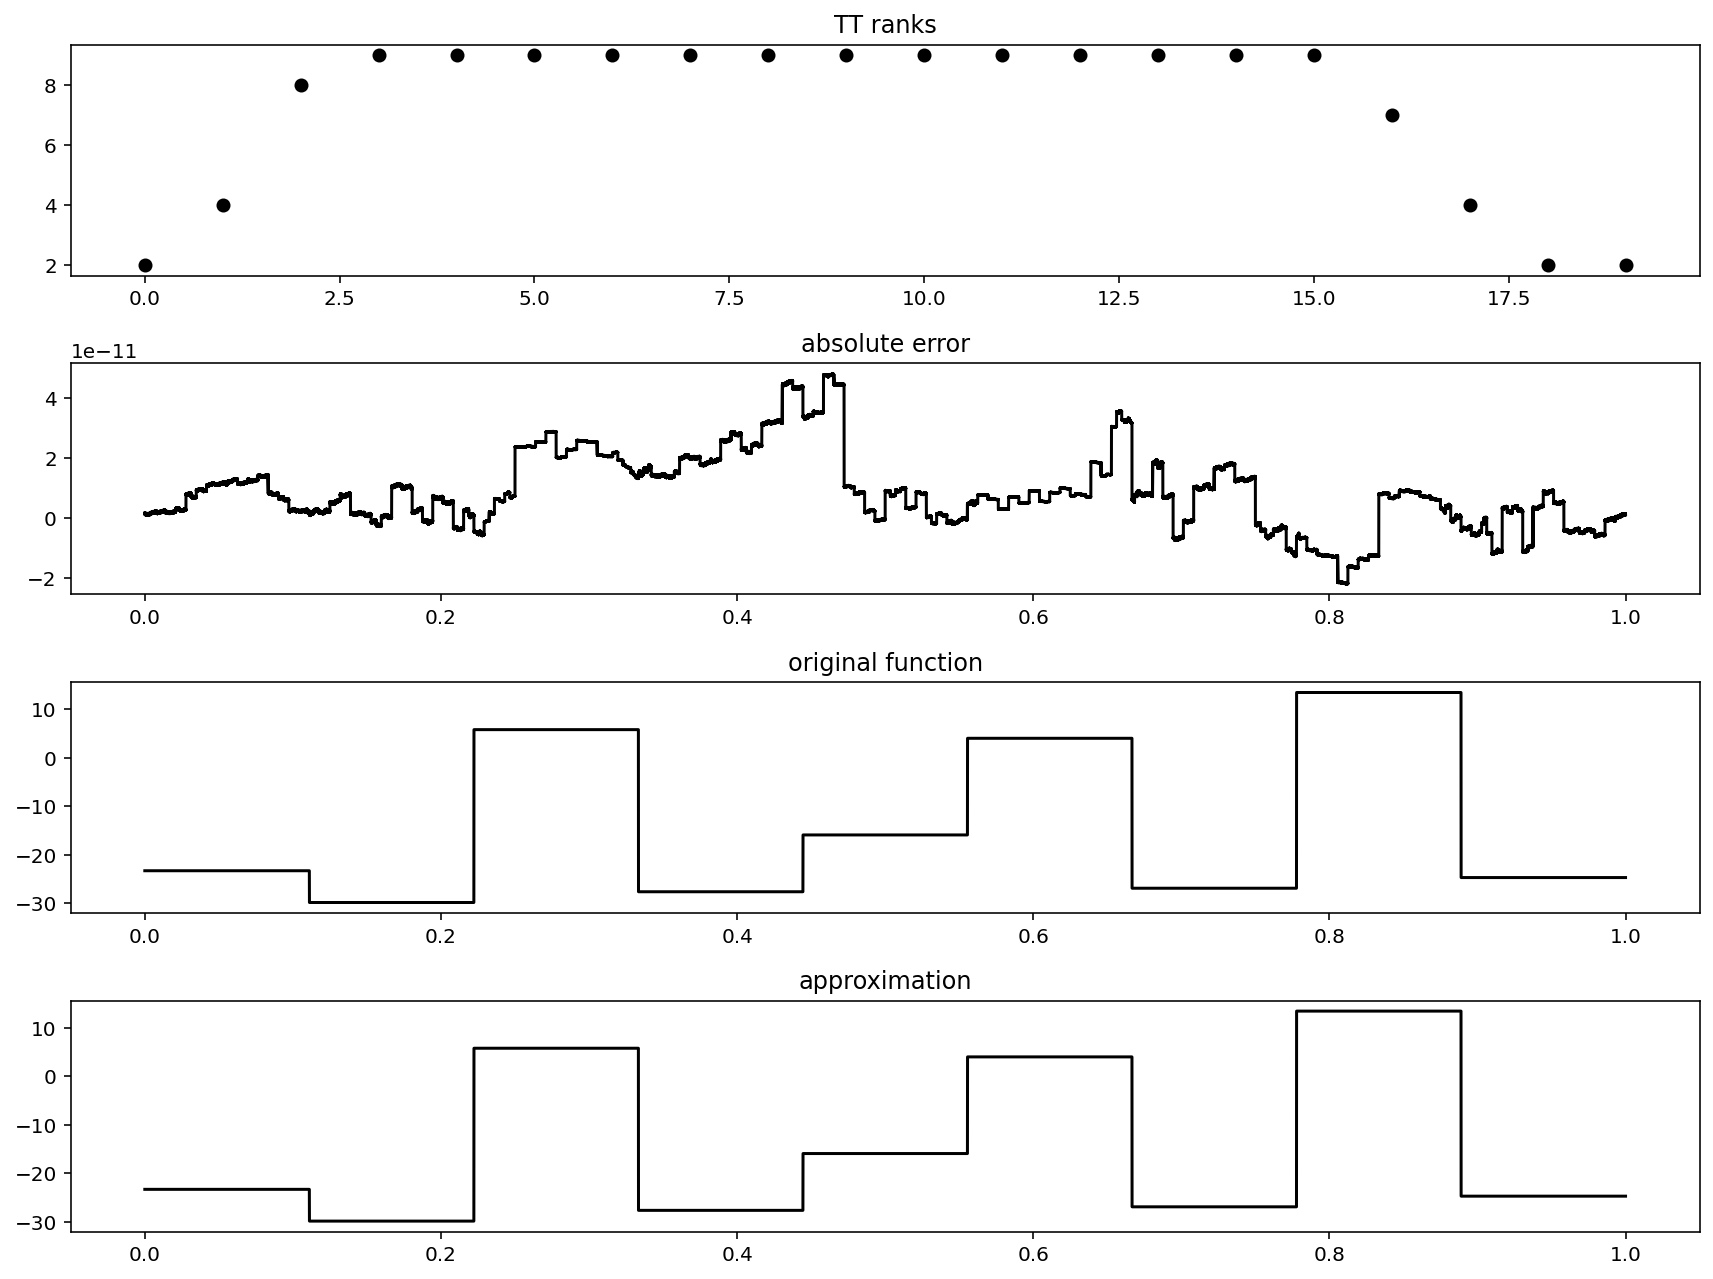

In [14]:
J = 20
x = jnp.linspace(0, 1, 2**J)

n_terms = 10
key = random.PRNGKey(33)
keys = random.split(key, 2)
c = jnp.linspace(0, 1, n_terms)#random.uniform(keys[0], (n_terms,))
v = 20*random.normal(keys[1], (n_terms-1,))
f = jnp.sum(jnp.stack([(x < stop) * (x >= start) * v[i] for i, start, stop in zip(range(n_terms-1), c[:-1], c[1:])], 0), 0)
f = f.at[-1].set(v[-1])
f = f.reshape([2,]*J)
QTT_experiment(f)

Compression factor 0.008121490478515625
Relative error 0.00025254911163141274


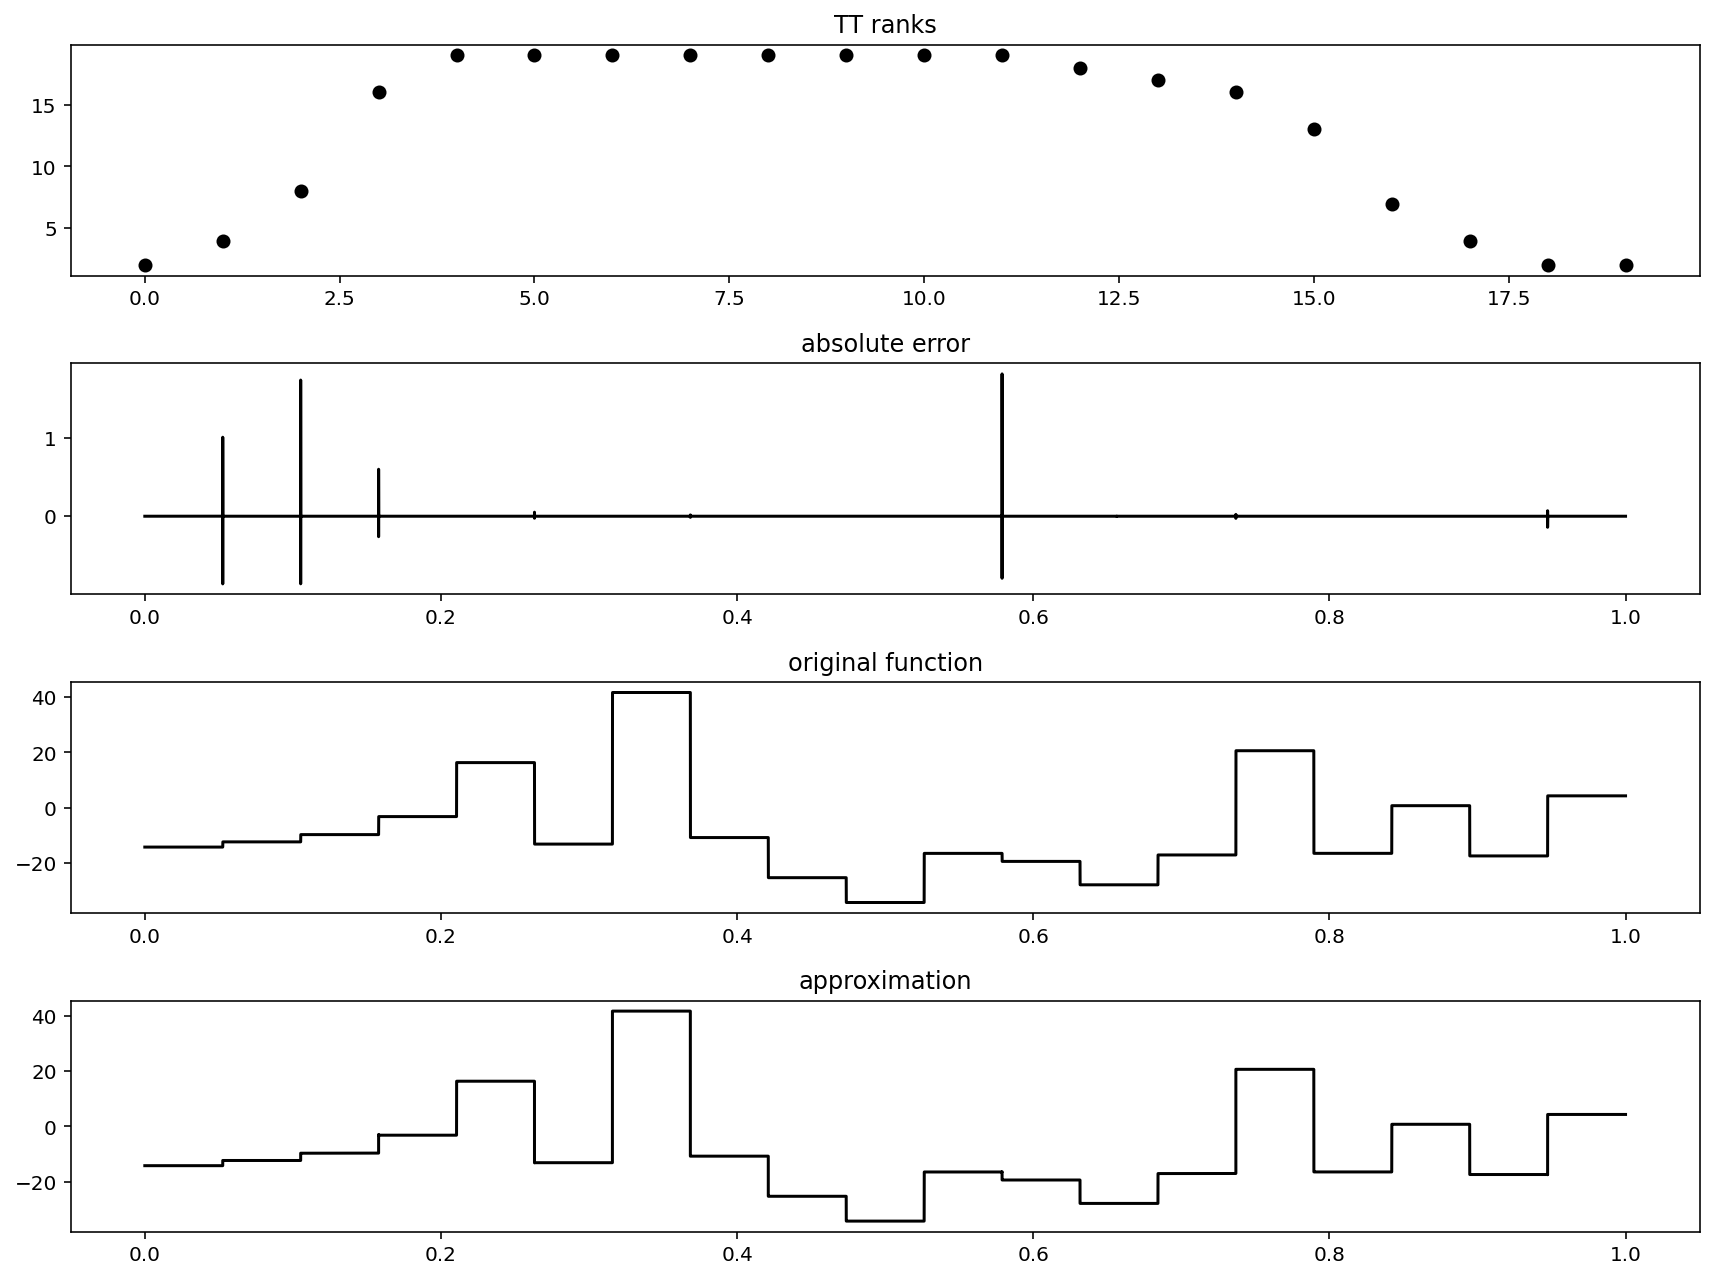

In [15]:
J = 20
x = jnp.linspace(0, 1, 2**J)

n_terms = 20
key = random.PRNGKey(33)
keys = random.split(key, 2)
c = jnp.linspace(0, 1, n_terms)#random.uniform(keys[0], (n_terms,))
v = 20*random.normal(keys[1], (n_terms-1,))
f = jnp.sum(jnp.stack([(x < stop) * (x >= start) * v[i] for i, start, stop in zip(range(n_terms-1), c[:-1], c[1:])], 0), 0)
f = f.at[-1].set(v[-1])
f = f.reshape([2,]*J)
QTT_experiment(f, epsilon=1e-3)

Compression factor 0.00850677490234375
Relative error 1.0374080634592563e-12


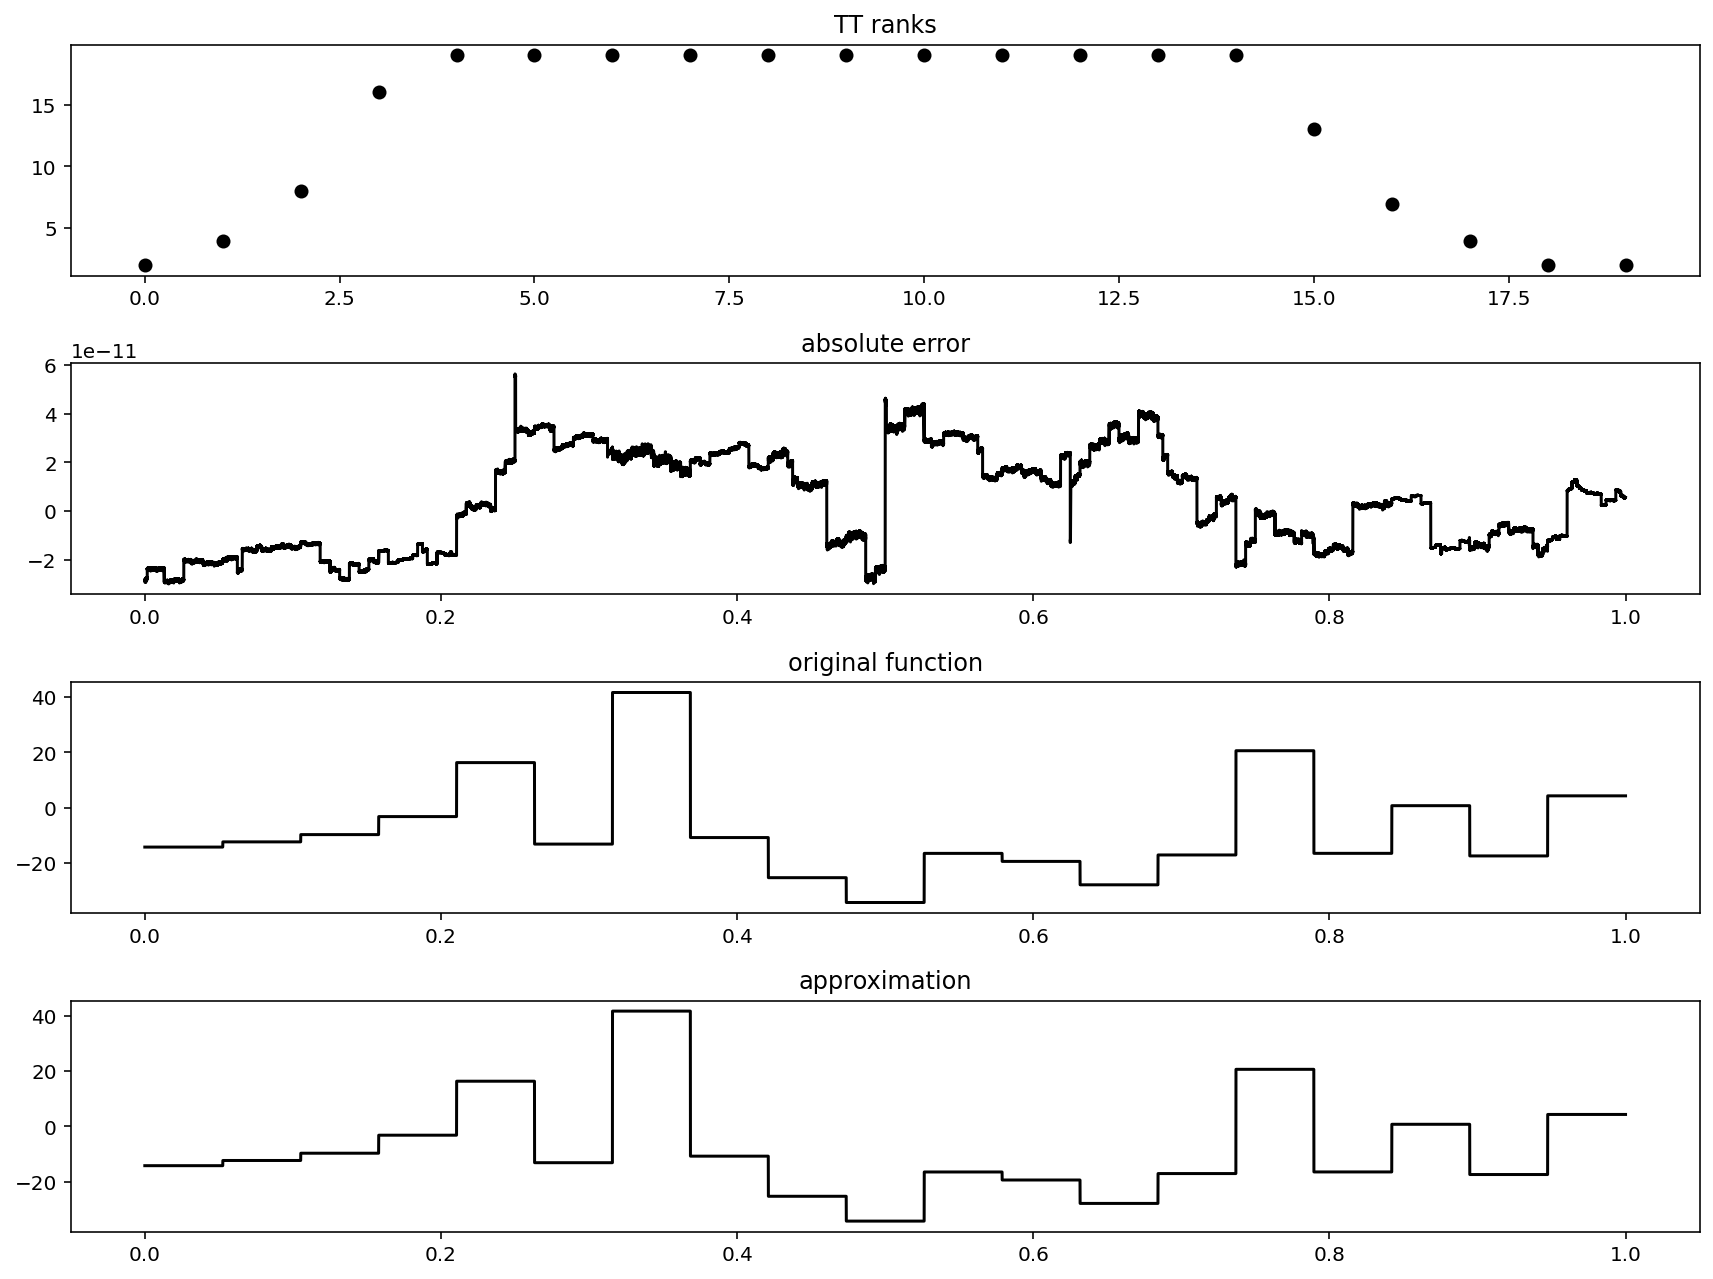

In [16]:
J = 20
x = jnp.linspace(0, 1, 2**J)

n_terms = 20
key = random.PRNGKey(33)
keys = random.split(key, 2)
c = jnp.linspace(0, 1, n_terms)
v = 20*random.normal(keys[1], (n_terms-1,))
f = jnp.sum(jnp.stack([(x < stop) * (x >= start) * v[i] for i, start, stop in zip(range(n_terms-1), c[:-1], c[1:])], 0), 0)
f = f.at[-1].set(v[-1])
f = f.reshape([2,]*J)
QTT_experiment(f, epsilon=1e-9)

### Chebyshev series

Compression factor 0.0009326934814453125
Relative error 3.613848219353574e-10


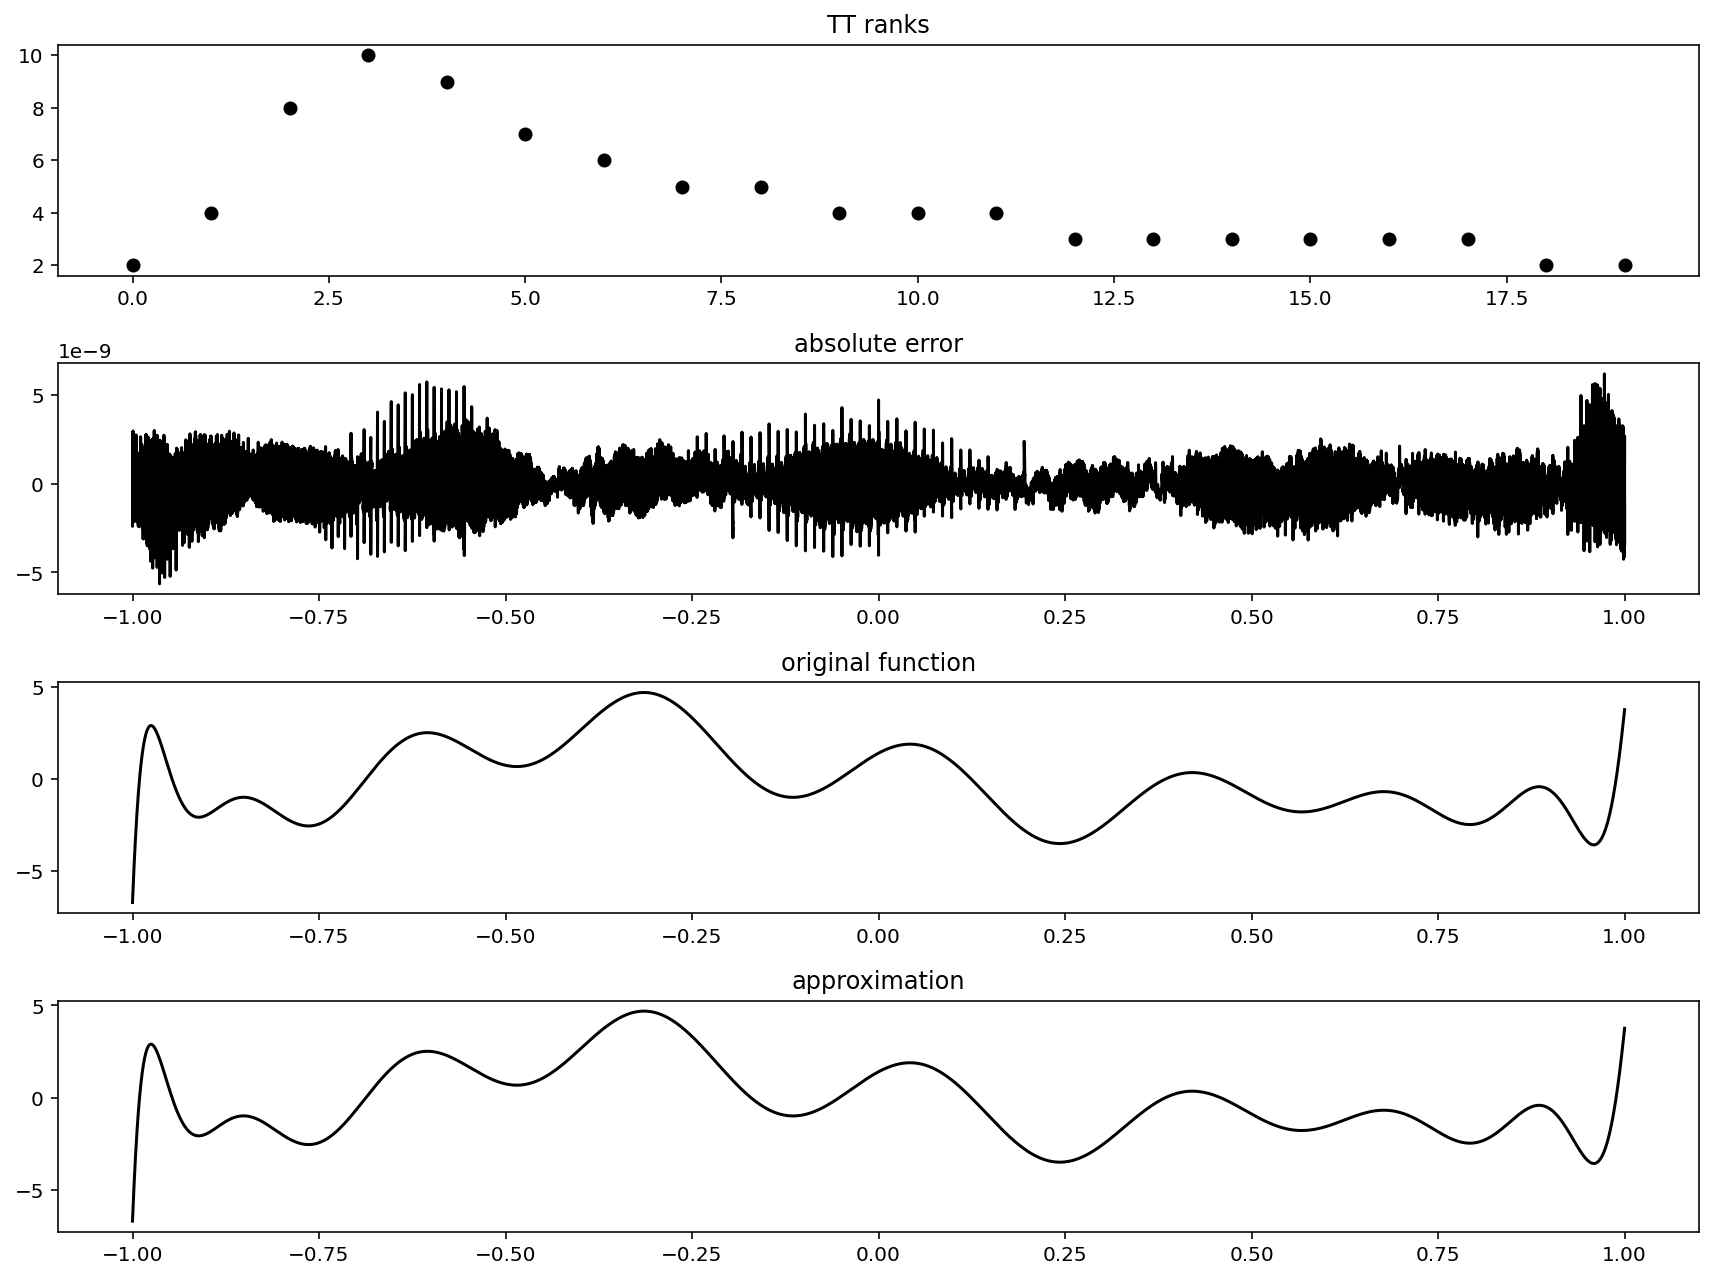

In [17]:
J = 20
x = jnp.array(jnp.cos(jnp.arange(2**J, dtype='int64')*jnp.pi/(2**J-1))[::-1], dtype='float64')

n_terms = 20
key = random.PRNGKey(33)
keys = random.split(key, 2)
v = random.normal(keys[1], (n_terms,))
f = jnp.sum(jnp.stack([v[n]*eval_chebyt(n, x) for n in range(n_terms)], 0), 0).reshape([2,]*J)
QTT_experiment(f, epsilon=1e-9)

Compression factor 0.0012302398681640625
Relative error 3.580605922012114e-10


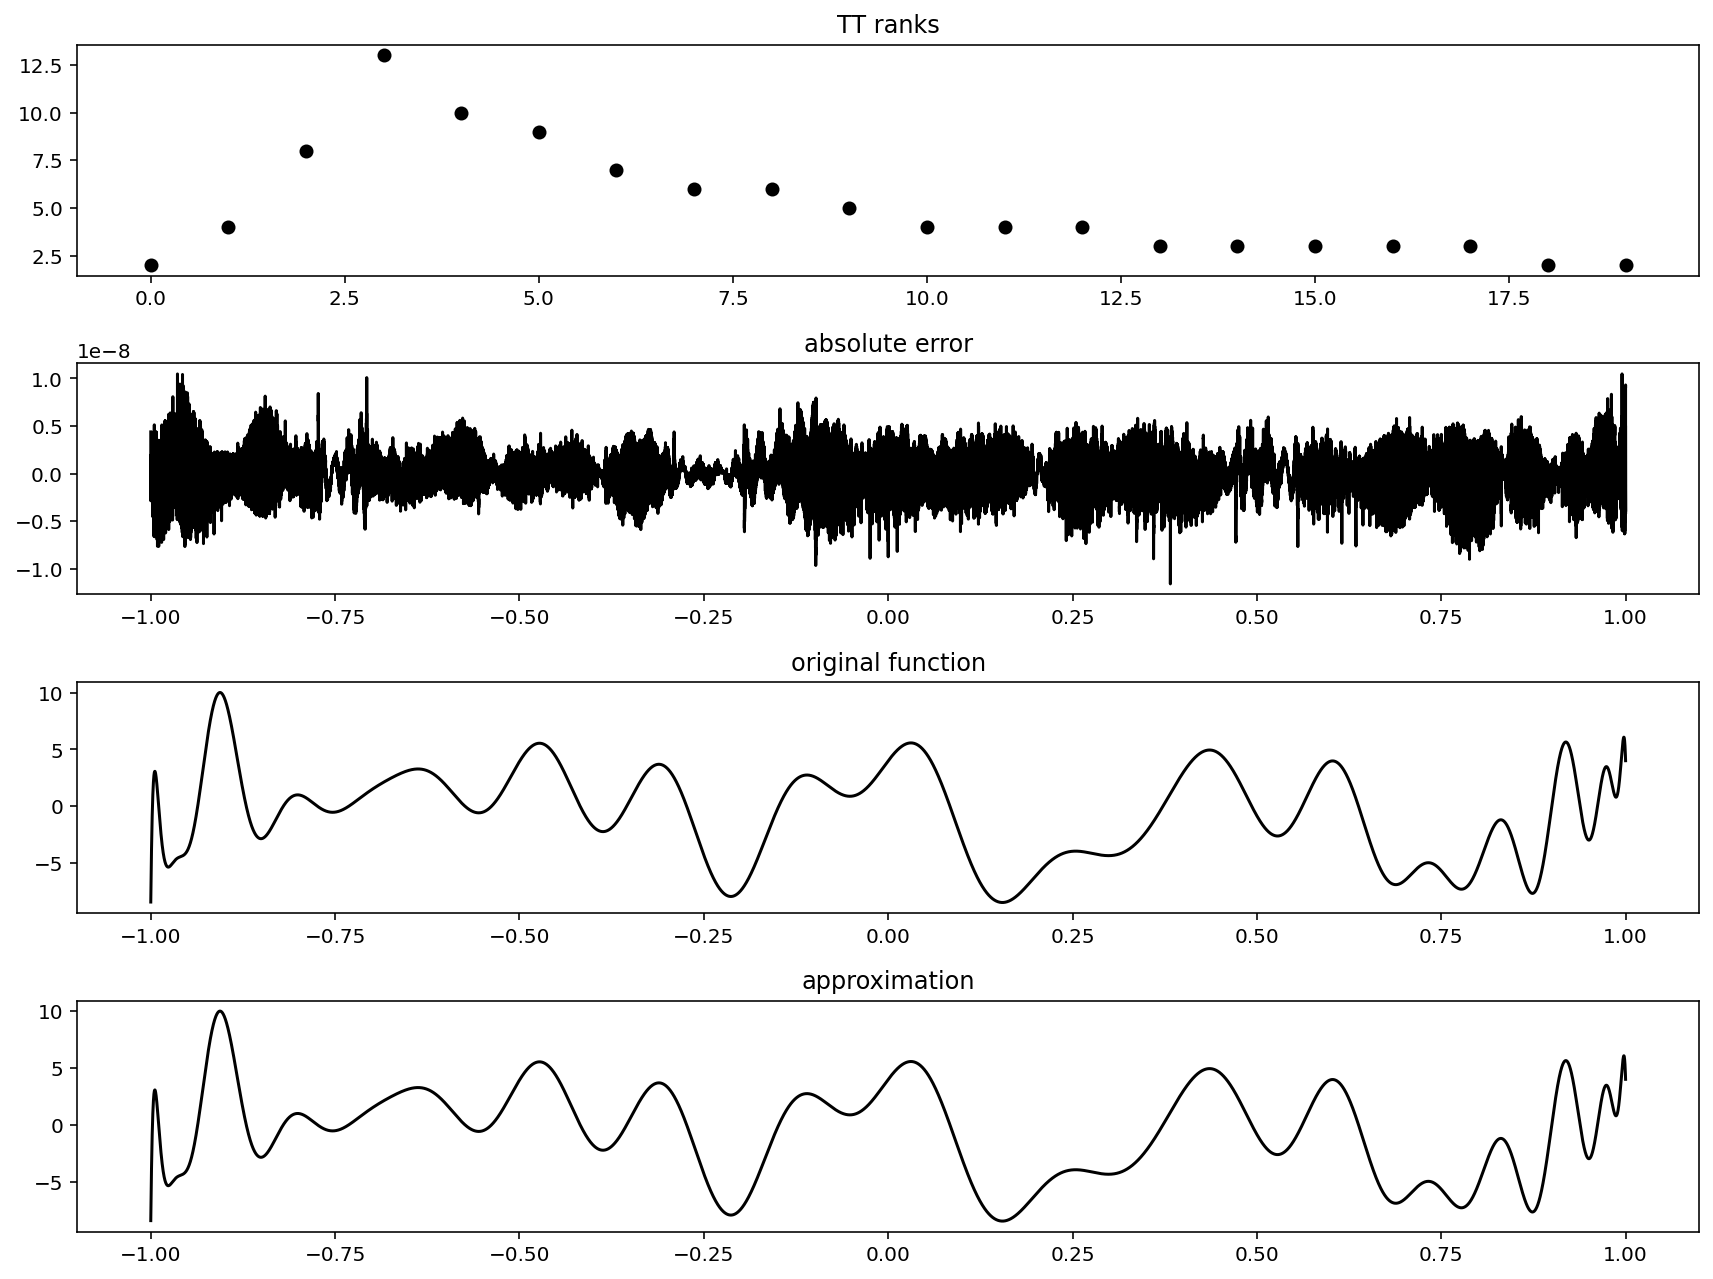

In [18]:
J = 20
x = jnp.array(jnp.cos(jnp.arange(2**J, dtype='int64')*jnp.pi/(2**J-1))[::-1], dtype='float64')

n_terms = 40
key = random.PRNGKey(33)
keys = random.split(key, 2)
v = random.normal(keys[1], (n_terms,))
f = jnp.sum(jnp.stack([v[n]*eval_chebyt(n, x) for n in range(n_terms)], 0), 0).reshape([2,]*J)
QTT_experiment(f, epsilon=1e-9)

### Chebyshev series $> 0$

Compression factor 0.064453125
Relative error 9.401290007984909e-07


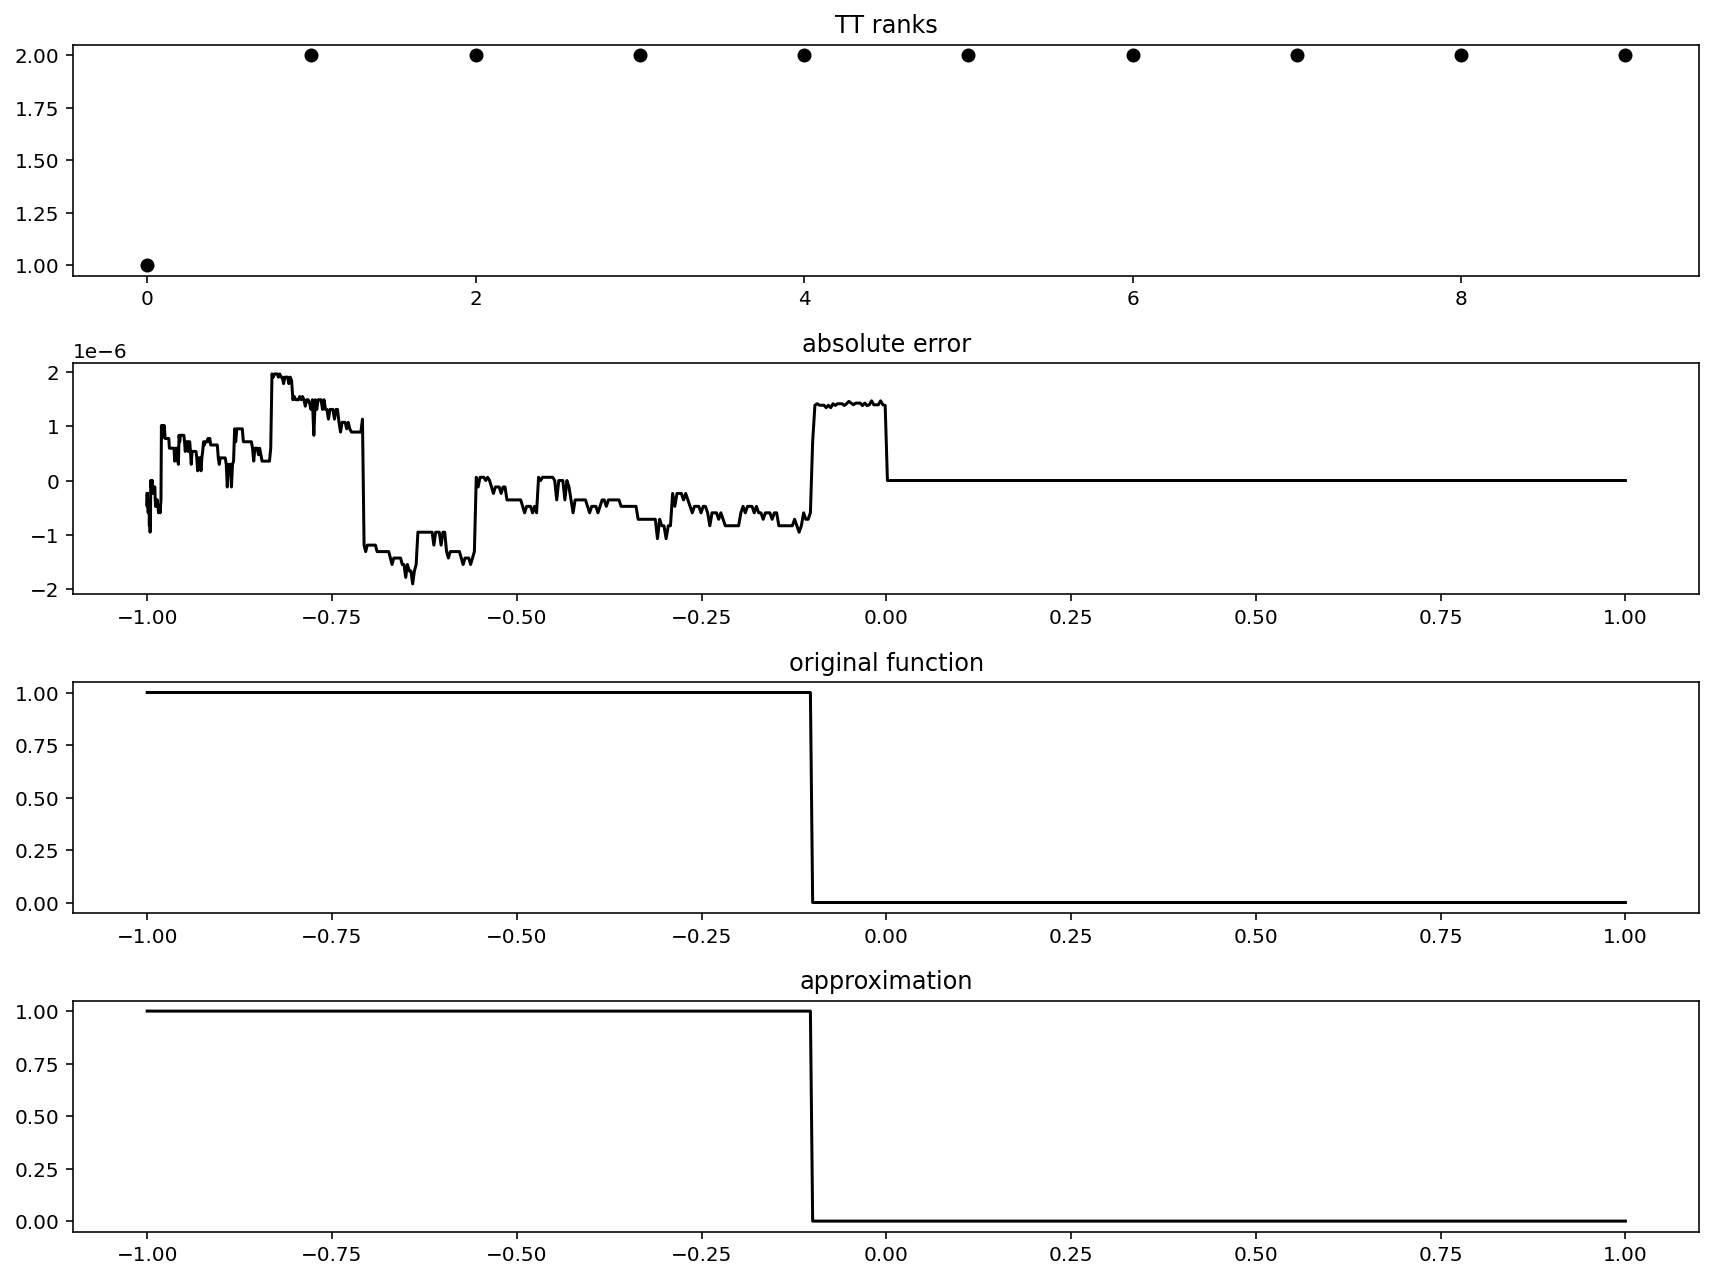

In [19]:
J = 10
x = jnp.array(jnp.cos(jnp.arange(2**J, dtype='int64')*jnp.pi/(2**J-1))[::-1], dtype='float64')

n_terms = 3
key = random.PRNGKey(33)
keys = random.split(key, 2)
v = random.normal(keys[1], (n_terms,))
f = jnp.sum(jnp.stack([v[n]*eval_chebyt(n, x) for n in range(n_terms)], 0), 0).reshape([2,]*J) >= 0
QTT_experiment(f, epsilon=1e-3)

## Example 2: High-dimensional function

We will try to approximate

\begin{equation}
    f(x) =\sin\left(\sum_{k=1}^{d} x_k\right),
\end{equation}

which is known to have a low-rank representation

\begin{equation}
    f(x) = 
    \begin{pmatrix}
      \sin(x_1) & \cos(x_1)
    \end{pmatrix}
    \begin{pmatrix}
      \cos(x_2) & -\sin(x_2) \\
      \sin(x_2) & \cos(x_2) \\
    \end{pmatrix}
    \cdots
    \begin{pmatrix}
      \cos(x_{d-1}) & -\sin(x_{d-1}) \\
      \sin(x_{d-1}) & \cos(x_{d-1}) \\
    \end{pmatrix}
    \begin{pmatrix}
      \cos(x_d) \\
      \sin(x_d)
    \end{pmatrix}.
\end{equation}

In [20]:
x = jnp.linspace(0, 1, 15)
coordinates = jnp.stack(jnp.meshgrid(*[x]*6), 0)
f = jnp.sin(jnp.sum(coordinates, 0))
F = jnp.sqrt(jnp.sum(f**2))

epsilon = 1e-2
delta = F*epsilon / jnp.sqrt(f.ndim - 1)

TT_cores = adaptive_TT(f, delta)

total_size = 0
for core in TT_cores:
    total_size += core.size
    print(core.shape)

compression_factor = total_size / f.size
print(f"Compression factor {compression_factor}")

(15, 2)
(2, 15, 2)
(2, 15, 2)
(2, 15, 2)
(2, 15, 2)
(2, 15)
Compression factor 2.6337448559670783e-05


## Example 3: Laplace operator

Second-order finite difference discretization of the Laplace operator leads to tridiagonal matrix $L$ with $[1, -2, 1]$ on diagonals.

Laplace operator in $\mathbb{R}^{d}$ reads

\begin{equation}
    L\otimes I \otimes \cdots \otimes I + I\otimes L \otimes \cdots \otimes I + \dots + I\otimes \cdots \otimes L.
\end{equation}

To form a tensor we mark each row and each column with multiplex $(i_1, i_2, \dots, i_d, j_1, j_2, \dots j_d)$ such that $i_{k}, j_{k}$ correspond to $k$-th dimension. We also situate related dimensions closer to each other $(i_1, j_1, \dots, i_d, j_d)$.

In [21]:
def increase_d(operator_list, I):
    operator_list_ = []
    for operator in operator_list:
        operator_list_.append(jnp.kron(operator, I))
        operator_list_.append(jnp.kron(I, operator))
    return operator_list_

In [22]:
N = 5
d = 5
L = -2*jnp.diag(jnp.ones(N), 0) + jnp.diag(jnp.ones(N-1), 1) + jnp.diag(jnp.ones(N-1), -1)
I = jnp.diag(jnp.ones(N), 0)
operator_list = [L,]
for _ in range(d-1):
    operator_list = increase_d(operator_list, I)

A = jnp.sum(jnp.stack(operator_list, 0), 0)
A = A.reshape([5,]*d + [5,]*d)
order = []
for i in range(d):
    order += [i, i+d]

A = jnp.transpose(A, order)

F = jnp.sqrt(jnp.sum(A**2))

epsilon = 1e-2
delta = F*epsilon / jnp.sqrt(A.ndim - 1)

TT_cores = adaptive_TT(A, delta)

total_size = 0
for core in TT_cores:
    total_size += core.size
    print(core.shape)

compression_factor = total_size / A.size
print(f"Compression factor {compression_factor}")

(5, 5)
(5, 5, 2)
(2, 5, 10)
(10, 5, 2)
(2, 5, 10)
(10, 5, 2)
(2, 5, 10)
(10, 5, 2)
(2, 5, 5)
(5, 5)
Compression factor 7.68e-05


Matrix after resordering.

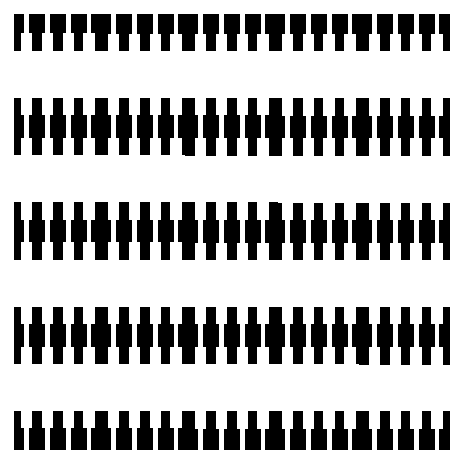

In [23]:
plt.spy(A.reshape(N**d, N**d), markersize=2, color="black")
plt.axis("off");

**Reordering step is important!** Below we compute TT without it, i.e., for the tensor with indices $(i_1, i_2, \dots, i_d, j_1, j_2, \dots j_d)$ and observe no compression.

In [24]:
N = 5
d = 5
L = -2*jnp.diag(jnp.ones(N), 0) + jnp.diag(jnp.ones(N-1), 1) + jnp.diag(jnp.ones(N-1), -1)
I = jnp.diag(jnp.ones(N), 0)
operator_list = [L,]
for _ in range(d-1):
    operator_list = increase_d(operator_list, I)

A = jnp.sum(jnp.stack(operator_list, 0), 0)
A = A.reshape([5,]*d + [5,]*d)
# order = []
# for i in range(d):
#     order += [i, i+d]

# A = jnp.transpose(A, order)

F = jnp.sqrt(jnp.sum(A**2))

epsilon = 1e-2
delta = F*epsilon / jnp.sqrt(A.ndim - 1)

TT_cores = adaptive_TT(A, delta)

total_size = 0
for core in TT_cores:
    total_size += core.size
    print(core.shape)

compression_factor = total_size / A.size
print(f"Compression factor {compression_factor}")

(5, 5)
(5, 5, 25)
(25, 5, 125)
(125, 5, 625)
(625, 5, 3124)
(3124, 5, 625)
(625, 5, 125)
(125, 5, 25)
(25, 5, 5)
(5, 5)
Compression factor 2.08269312


The sparsity pattern for the matrix without reordering.

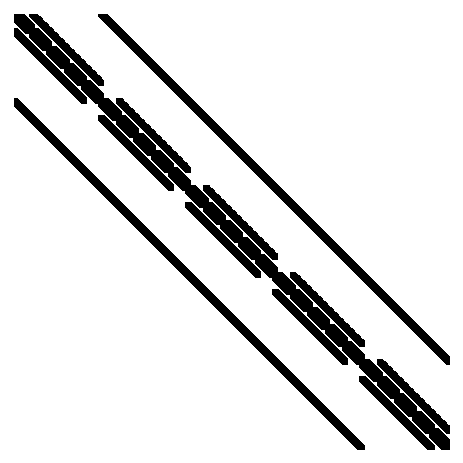

In [25]:
plt.spy(A.reshape(N**d, N**d), markersize=2, color="black")
plt.axis("off");